In [33]:
from google.cloud import storage
import json
def read_gcs_file(bucket_name, file_path):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(file_path)
    file_content = blob.download_as_text()
    data_list = [json.loads(line) for line in file_content.splitlines()]
    return data_list

In [56]:
aya23_langs ={
    "ar": "Arabic",
    "zh-CN": "Chinese (Simplified)",
    "zh-TW": "Chinese (Traditional)",
    "cs": "Czech",
    "nl": "Dutch",
    "en": "English",
    "fr": "French",
    "de": "German",
    "el": "Greek",
    "he": "Hebrew",
    "hi": "Hindi",
    "id": "Indonesian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "fa": "Persian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "es": "Spanish",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
}

aya23_nllbcode2cloudcode ={
    "arb_Arab": "ar",
    "zho_Hans": "zh-CN",
    "zho_Hant": "zh-TW",
    "ces_Latn": "cs",
    "nld_Latn": "nl",
    "eng_Latn": "en",
    "fra_Latn": "fr",
    "deu_Latn": "de",
    "ell_Grek": "el",
    "heb_Hebr": "he",
    "hin_Deva": "hi",
    "ind_Latn": "id",
    "ita_Latn": "it",
    "jpn_Jpan": "ja",
    "kor_Hang": "ko",
    "pes_Arab": "fa",
    "pol_Latn": "pl",
    "por_Latn": "pt",
    "ron_Latn": "ro",
    "rus_Cyrl": "ru",
    "spa_Latn": "es",
    "tur_Latn": "tr",
    "ukr_Cyrl": "uk",
    "vie_Latn": "vi",
}

aya23_cloudcode2nllbcode = {v: k for k, v in aya23_nllbcode2cloudcode.items()}

In [57]:
len(aya23_langs)

24

In [58]:
from google.cloud import translate
import time

PROJECT_ID = "valued-sight-253418"

def translate_text(text, target_language_code):
    """Translating Text."""

    client = translate.TranslationServiceClient()

    parent = f"projects/{PROJECT_ID}"

    tries = 0

    while tries < 10:
        try:
            response = client.translate_text(
                request={
                    "parent": parent,
                    "contents": [text],
                    "mime_type": "text/plain",  
                    "source_language_code": "en-US",
                    "target_language_code": target_language_code,
                }
            )
            return  response.translations[0].translated_text #[translation.translated_text for translation in response.translations]
        
        except Exception as e:
                print(e)
                time.sleep(5)
                tries += 1
                continue

    return None

In [61]:
import datasets
dataset = datasets.load_dataset("olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages")  

In [66]:
rename_dict = {f"question_{v}": f"question_{k}" for k, v in aya23_nllbcode2cloudcode.items()}
dataset = dataset.rename_columns(rename_dict)


In [68]:
dataset.push_to_hub("olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages")

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages/commit/6f8b1f41043c50df0d1c86aa55e8a230a83dc7da', commit_message='Upload dataset', commit_description='', oid='6f8b1f41043c50df0d1c86aa55e8a230a83dc7da', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages', endpoint='https://huggingface.co', repo_type='dataset', repo_id='olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages'), pr_revision=None, pr_num=None)

In [62]:
import datasets

dataset = datasets.load_dataset("olivernan/cauldron_eval_sample_w_gpt_questions")['train']
dataset = dataset.rename_columns({"random_pick_generated_question": "question_en"})

for code, lang in aya23_langs.items():
    print(f"Translating to {lang}")
    if code == "en":
        continue
    column_name = f"question_{code}"
    print(column_name)
    dataset = dataset.map(lambda x: {column_name: translate_text(x["question_en"], code)}, num_proc=10)
    # break
        

Translating to Arabic
question_ar
Translating to Chinese (Simplified)
question_zh-CN
Translating to Chinese (Traditional)
question_zh-TW
Translating to Czech
question_cs
Translating to Dutch
question_nl
Translating to English
Translating to French
question_fr
Translating to German
question_de
Translating to Greek
question_el
Translating to Hebrew
question_he
Translating to Hindi
question_hi
Translating to Indonesian
question_id
Translating to Italian
question_it
Translating to Japanese
question_ja
Translating to Korean
question_ko
Translating to Persian
question_fa
Translating to Polish
question_pl
Translating to Portuguese
question_pt
Translating to Romanian
question_ro
Translating to Russian
question_ru
Translating to Spanish
question_es
Translating to Turkish
question_tr
Translating to Ukrainian
question_uk
Translating to Vietnamese
question_vi


In [38]:
import copy
dataset_copy = copy.deepcopy(dataset)

In [39]:
dataset_columns = dataset_copy.column_names
column_reorder = ["index"] + [col for col in dataset_columns if col != "index"]
dataset_reordered = dataset_copy.select_columns(column_reorder)

In [40]:
dataset_reordered

Dataset({
    features: ['index', 'image', 'data_source', 'task_category', 'gpt_4o_generated_questions', 'question_en', 'question_ar', 'question_zh-CN', 'question_zh-TW', 'question_cs', 'question_nl', 'question_fr', 'question_de', 'question_el', 'question_he', 'question_hi', 'question_id', 'question_it', 'question_ja', 'question_ko', 'question_fa', 'question_pl', 'question_pt', 'question_ro', 'question_ru', 'question_es', 'question_tr', 'question_uk', 'question_vi'],
    num_rows: 450
})

In [41]:
dataset_reordered = dataset_reordered.to_dict()

In [42]:
from datasets import Dataset, Features, Sequence, Image, Value
dataset_reordered = datasets.Dataset.from_dict(dataset_reordered, 
                                features=Features({
                                    'index': Value(dtype='int32', id=None),
                                    'image': Sequence(feature=Image(mode=None, decode=True, id=None), length=-1, id=None), 
                                    'data_source': Value(dtype='string', id=None),
                                    'task_category': Value(dtype='string', id=None),
                                    "gpt_4o_generated_questions": Sequence(
                                        feature=Value(dtype="string", id=None), length=-1, id=None
                                    ),
                                    "question_en": Value(dtype="string", id=None),
                                    "question_ar": Value(dtype="string", id=None),
                                    "question_zh-CN": Value(dtype="string", id=None),
                                    "question_zh-TW": Value(dtype="string", id=None),
                                    "question_cs": Value(dtype="string", id=None),
                                    "question_nl": Value(dtype="string", id=None),
                                    "question_fr": Value(dtype="string", id=None),
                                    "question_de": Value(dtype="string", id=None),
                                    "question_el": Value(dtype="string", id=None),
                                    "question_he": Value(dtype="string", id=None),
                                    "question_hi": Value(dtype="string", id=None),
                                    "question_id": Value(dtype="string", id=None),
                                    "question_it": Value(dtype="string", id=None),
                                    "question_ja": Value(dtype="string", id=None),
                                    "question_ko": Value(dtype="string", id=None),
                                    "question_fa": Value(dtype="string", id=None),
                                    "question_pl": Value(dtype="string", id=None),
                                    "question_pt": Value(dtype="string", id=None),
                                    "question_ro": Value(dtype="string", id=None),
                                    "question_ru": Value(dtype="string", id=None),
                                    "question_es": Value(dtype="string", id=None),
                                    "question_tr": Value(dtype="string", id=None),
                                    "question_uk": Value(dtype="string", id=None),
                                    "question_vi": Value(dtype="string", id=None),
                                })
                                )

In [43]:
dataset_reordered.push_to_hub("olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages/commit/ceff323b001308ec9ff55a7fc0a79d40f029f18f', commit_message='Upload dataset', commit_description='', oid='ceff323b001308ec9ff55a7fc0a79d40f029f18f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages', endpoint='https://huggingface.co', repo_type='dataset', repo_id='olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages'), pr_revision=None, pr_num=None)

# cauldron_eval_sample_w_gpt_questions multilingual Bee formatting

In [70]:
import io
import base64
import json
import math 
from PIL import Image
import datasets


dataset = datasets.load_dataset("olivernan/cauldron_eval_sample_w_gpt_questions_aya23languages")['train']
def to_bytes(image):
    img_byte_arr = io.BytesIO()
    image.convert("RGB").save(img_byte_arr, format="jpeg")
    return img_byte_arr.getvalue()

def resize_and_pad_image(image, target_resolution):
    """
    Resize and pad an image to a target resolution while maintaining aspect ratio.

    Args:
        image (PIL.Image.Image): The input image.
        target_resolution (tuple): The target resolution (width, height) of the image.

    Returns:
        PIL.Image.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_resolution

    scale_w = target_width / original_width
    scale_h = target_height / original_height

    if scale_w < scale_h:
        new_width = target_width
        new_height = min(math.ceil(original_height * scale_w), target_height)
    else:
        new_height = target_height
        new_width = min(math.ceil(original_width * scale_h), target_width)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    new_image = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

with open(f'/home/olivernan_cohere_com/cauldron_eval_sample_w_gpt_questions_aya23languages_all_resize_768_768.jsonl', "w+") as f:
    for i, data in enumerate(dataset):
        for key, lang in aya23_langs.items():
            # column_name = f"question_{key}"
            column_name = f"question_{aya23_cloudcode2nllbcode[key]}"
            data_json = {}
            data_json['images'] = []
            data_json['turns'] = []
            data_json['turns'].append({'role': 'User', "message": []})
            data_json['turns'][0]['message'].append({"text": data[column_name]})
            for image in data['image']:
                # width, height = image.size
                # if width >= 256 or height >= 256:
                image = resize_and_pad_image(image, (768, 768))
                data_json['turns'][0]['message'].append({"url": f"data:image/jpeg;base64,{base64.b64encode(to_bytes(image)).decode('utf-8')}"})
                data_json['images'].append(f"data:image/jpeg;base64,{base64.b64encode(to_bytes(image)).decode('utf-8')}")
            data_json['prompt'] = data[column_name]
            data_json['completion'] = ""
            data_json['index'] = data['index']
            data_json['data_source'] = data['data_source']
            data_json['task_category'] = data['task_category']
            data_json['language'] = lang
            f.write(json.dumps(data_json) + "\n")

In [51]:
import json
with open("/home/olivernan_cohere_com/recap_cauldron_translation_2024_10_11_raw/RecapCauldronSpot_the_diff_translation/zho_Hant/train.jsonl", "r") as f:
    # for line in f:
    #     print(json.loads(line) )
    #     break
    dataset = [json.loads(line) for line in f]

{'split': 'train',
 'turns': [{'role': 'User',
   'content': [{'text': '這兩張圖有何不同?'},
    {'url': ''},
    {'url': ''}]},
  {'role': 'Chatbot',
   'content': '分析一下兩張相片的不同之處: 其他國家 1. **照明與影子**:檢查傘和家具的影子. 燈光的變化可能表明一天的不同時間或天氣狀況. 其他國家 2. **家具的擺設**:請仔細看看桌椅的擺設. 任何不同排列可能表明使用或設置有所改變. 其他國家 3. **景觀細節**:注意綠色的變化, 照片可能會顯示更健康的草<unk>或更顯著的植被. 其他國家 4. **人與活動**:如果在一張圖片上有數字,但在另一張圖片上沒有, 其他國家 5. **物品或裝飾品**:檢查任何額外的物品,如裝飾品,標誌或設備, 其他國家 6. **視角與角度**:請考慮每張照片的拍攝角度. 這樣的改變也會改變人們對景象的看法. 其他國家 這兩種圖像之間的差異,'}],
 'metadata': {'source': 'Spot-the-diff'},
 'command_id': 'CauldronSpot_the_diff-Spot-the-diff-7875',
 'snapshot_sha_hash': '11a0694a7cc26cfad248e85245c0329071cb330095ecfc9ed03d5d768e1f0361'}
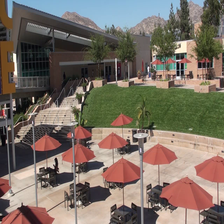
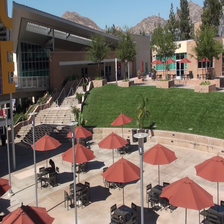

In [55]:
dataset[2]